# LGBM을 활용한 베이스라인

In [1]:
import pandas as pd
import os
import random
from tqdm import tqdm
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import pickle

## 1. 데이터 로딩

In [2]:
data_dir = '/opt/ml/project/data/' # 경로는 상황에 맞춰서 수정해주세요!
csv_file_path = os.path.join(data_dir, 'total_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
df = pd.read_csv(csv_file_path, parse_dates=['Timestamp']) 
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

## 2. Feature Engineering

In [7]:
def calculate_statistics(df):
    df['testType'] = df['testId'].apply(lambda x:x[:3])
    
    temp_df = df[df['answerCode'] != -1].copy()
    
    correct_i = temp_df.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum', 'std'])
    correct_i.columns = ["question_mean", 'question_sum', 'question_std']
    correct_t = temp_df.groupby(['testId'])['answerCode'].agg(['mean', 'sum', 'std'])
    correct_t.columns = ["test_mean", 'test_sum', 'test_std']
    correct_k = temp_df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum', 'std'])
    correct_k.columns = ["tag_mean", 'tag_sum', 'tag_std']
    type_df = temp_df.groupby('testType')['answerCode'].agg(['mean', 'sum', 'std'])
    type_df.columns = ['type_mean', 'type_sum', 'type_std']
    
    corr_df = temp_df.groupby('assessmentItemID')['answerCode'].agg([['corr_ratio', 'mean']]).reset_index()
    corr_df = temp_df[temp_df['answerCode']==0].merge(corr_df, on='assessmentItemID')
    corr_df = corr_df.groupby('userID')['corr_ratio'].agg(['min', 'max', 'mean', 'std']).reset_index()
    corr_df.columns = ['userID', 'corr_min', 'corr_max', 'corr_mean', 'corr_std']
    
    df = pd.merge(df, correct_i, on=['assessmentItemID'], how="left")
    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    df = pd.merge(df, type_df, on=['testType'], how="left")
    df = pd.merge(df, corr_df, on=['userID'], how='left')
    
    return df


def calculate_user_accuracy(df):
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']
    
    tag_user_acc = df.groupby(['userID','KnowledgeTag'])['answerCode'].agg(['mean'])
    df = pd.merge(df, tag_user_acc, on=['userID','KnowledgeTag'], how="left")
    
    return df


def calculate_user_accuracy_trend(df):
    for window_size in [3, 5, 10, 30, 50, 100, 200]:
        user_df = df.groupby(df['userID']).shift(1)
        user_accuracy_trend = user_df.groupby(df['userID']).answerCode.rolling(window=window_size, min_periods=1).mean()
        user_correct_trend = user_df.groupby(df['userID']).answerCode.rolling(window=window_size, min_periods=1).sum()
        
        
        df[f'user_accuracy_trend{window_size}'] = user_accuracy_trend.values
        df[f'normalized_user_accuracy_trend{window_size}'] = df[f'user_accuracy_trend{window_size}'] - df['question_mean']
        df[f'user_correct_trend{window_size}'] = user_correct_trend.values
        
    return df


def calculate_accuracy_on_past_attempts(df):
    # 과거 똑같은 문제 count/correct/accuracy
    df['past_question_count'] = df.groupby(['userID', 'assessmentItemID']).cumcount()
    df['shift'] = df.groupby(['userID', 'assessmentItemID'])['answerCode'].shift().fillna(0)
    df['past_question_correct'] = df.groupby(['userID', 'assessmentItemID'])['shift'].cumsum()
    df['past_question_accuracy'] = (df['past_question_correct'] / df['past_question_count']).fillna(0)
    
    # 과거 똑같은 태그 count/correct/accuracy
    df['past_tag_count'] = df.groupby(['userID', 'KnowledgeTag']).cumcount()
    df['shift'] = df.groupby(['userID', 'KnowledgeTag'])['answerCode'].shift().fillna(0)
    df['past_tag_correct'] = df.groupby(['userID', 'KnowledgeTag'])['shift'].cumsum()
    df['past_tag_accuracy'] = (df['past_tag_correct'] / df['past_tag_count']).fillna(0)
    
    # 과거 똑같은 Type count/correct/accuracy
    df['past_type_count'] = df.groupby(['userID', 'testType']).cumcount()
    df['shift'] = df.groupby(['userID', 'testType'])['answerCode'].shift().fillna(0)
    df['past_type_correct'] = df.groupby(['userID', 'testType'])['shift'].cumsum()
    df['past_type_accuracy'] = (df['past_type_correct'] / df['past_type_count']).fillna(0)
    
    # 과거 똑같은 문제 푼지 얼마나 되었는지
    shift = df.groupby(['userID', 'assessmentItemID'])['Timestamp'].shift()
    last_question_elapsedTime = (df['Timestamp'].values - shift.values) / np.timedelta64(1, 's')
    last_question_elapsedTime[np.isnan(last_question_elapsedTime)] = 0
    df['past_question_elapsedTime'] = last_question_elapsedTime

    # 과거 똑같은 태그 푼지 얼마나 되었는지
    shift = df.groupby(['userID', 'KnowledgeTag'])['Timestamp'].shift()
    last_tag_elapsedTime = (df['Timestamp'].values - shift.values) / np.timedelta64(1, 's')
    last_tag_elapsedTime[np.isnan(last_tag_elapsedTime)] = 0
    df['past_tag_elapsedTime'] = last_tag_elapsedTime

    # 과거 똑같은 Type 푼지 얼마나 되었는지
    shift = df.groupby(['userID', 'testType'])['Timestamp'].shift()
    last_tag_elapsedTime = (df['Timestamp'].values - shift.values) / np.timedelta64(1, 's')
    last_tag_elapsedTime[np.isnan(last_tag_elapsedTime)] = 0
    df['past_type_elapsedTime'] = last_tag_elapsedTime
    
    return df


def calculate_time_slot(df):
    df['day'] = df.Timestamp.dt.day
    df['time'] = df.Timestamp.apply(lambda x: x.value // 10**9)
    
    # 문제를 푸는 시간대
    df['hour'] = df['Timestamp'].transform(lambda x: x.dt.hour)

    # 시간대별 정답률
    temp_df = df[df['answerCode'] != -1].copy()
    hour_dict = temp_df.groupby(['hour'])['answerCode'].mean().to_dict()
    df['accuracy_per_hour'] = df['hour'].map(hour_dict)
    
    # 사용자의 주 활동 시간
    mode_dict = df.groupby(['userID'])['hour'].agg(lambda x: pd.Series.mode(x)[0]).to_dict()
    df['hour_mode'] = df['userID'].map(mode_dict)
    df['is_night'] = (df['hour_mode'] >= 18).values | (df['hour_mode'] < 6).values
    return df


def calculate_elapsedTime(df):
    # 걸린 시간
    def calculate_elapsd_time(df, offset):
        elapsed_time = df.Timestamp.shift(-1) - df.Timestamp
        elapsed_time = elapsed_time.values / np.timedelta64(1, 's')
        time_cond1 = elapsed_time > 0
        time_cond2 = elapsed_time < offset
        elapsed_time[~(time_cond1 & time_cond2)] = elapsed_time[time_cond1 & time_cond2].mean()
        
        return elapsed_time
    
    for offset in ['', 3600]:
        if offset == '':
            df[f'elapsedTime{offset}'] = calculate_elapsd_time(df, offset=600)
        else :
            df[f'elapsedTime{offset}'] = calculate_elapsd_time(df, offset=offset)
        df[f'normalized_elapsedTime{offset}'] = df.groupby('userID')[f'elapsedTime{offset}'].transform(lambda x: (x - x.mean())/x.std())
        df[f'relative_elapsedTime{offset}'] = df.groupby('userID').apply(lambda x: x[f'elapsedTime{offset}'] - x[f'elapsedTime{offset}'].median()).values
        
        # 유저 별 all/correct/wrong 걸린 시간 평균
        user_df = df.groupby('userID')[f'elapsedTime{offset}'].agg(['mean'])
        user_correct_df = df[df['answerCode'] == 1].groupby('userID')[f'elapsedTime{offset}'].agg(['mean'])
        user_wrong_df = df[df['answerCode'] == 0].groupby('userID')[f'elapsedTime{offset}'].agg(['mean'])
        
        user_df.columns = [f'user_elapsedTime_mean{offset}']
        user_correct_df.columns = [f'user_correct_elapsedTime_mean{offset}']
        user_wrong_df.columns = [f'user_wrong_elapsedTime_mean{offset}']

        df = pd.merge(df, user_df, on=['userID'], how="left")
        df = pd.merge(df, user_correct_df, on=['userID'], how="left")
        df = pd.merge(df, user_wrong_df, on=['userID'], how="left")
        
        # 문제 별 all/correct/wrong 걸린 시간 평균
        question_df = df.groupby('assessmentItemID')[f'elapsedTime{offset}'].agg(['mean'])
        question_correct_df = df[df['answerCode'] == 1].groupby('assessmentItemID')[f'elapsedTime{offset}'].agg(['mean'])
        question_wrong_df = df[df['answerCode'] == 0].groupby('assessmentItemID')[f'elapsedTime{offset}'].agg(['mean'])
        
        question_df.columns = [f'question_elapsedTime_mean{offset}']
        question_correct_df.columns = [f'question_correct_elapsedTime_mean{offset}']
        question_wrong_df.columns = [f'question_wrong_elapsedTime_mean{offset}']
        
        df = pd.merge(df, question_df, on=['assessmentItemID'], how="left")
        df = pd.merge(df, question_correct_df, on=['assessmentItemID'], how="left")
        df = pd.merge(df, question_wrong_df, on=['assessmentItemID'], how="left")

    return df


def calculate_roll_elapsedTime(df):
    # 최근 걸린 시간 평균
    for window_size in [3, 5, 10, 30, 50, 100, 200]:
        df[f'roll_elapsedTime_mean{window_size}'] = df.groupby(['userID'])['elapsedTime'].rolling(window_size).mean().values
            
    return df


def dimension_reduction(df):
    # Truncated SVD
    SVD_DIM = 5
    with open('./assets/svd.pickle','rb') as f:
         svd_dict = pickle.load(f)
         
    svd_df = pd.DataFrame.from_dict(svd_dict).T
    cols = [f'svd{i+1}' for i in range(SVD_DIM)]
    cols.insert(0, 'assessmentItemID')
    svd_df = svd_df.reset_index()
    svd_df.columns = cols
    df = pd.merge(df, svd_df, how='left', on='assessmentItemID')
    
    LDA_DIM = 5
    # 문제들에 대한 유저별 정답 횟수 행렬 LDA
    transformed = np.load(f'./assets/lda_question_dim{LDA_DIM}.npy')
    transformed_df = pd.DataFrame(transformed)
    transformed_df.columns = [f'lda_question{i+1}' for i in range(LDA_DIM)]
    transformed_df = transformed_df.astype(np.float32)
    transformed_df['assessmentItemID'] = sorted(df.assessmentItemID.unique())
    df = pd.merge(df, transformed_df, how='left', on='assessmentItemID')
    
    # 문제들에 대한 유저별 오답 횟수 행렬 LDA (answerCode == 0 filtering)
    wrong_transformed = np.load(f'./assets/lda_wrong_question_dim{LDA_DIM}.npy')
    wrong_transformed_df = pd.DataFrame(wrong_transformed)
    wrong_transformed_df.columns = [f'lda_wrong_question{i+1}' for i in range(LDA_DIM)]
    wrong_transformed_df = wrong_transformed_df.astype(np.float32)
    wrong_transformed_df['assessmentItemID'] = sorted(df.assessmentItemID.unique())
    df = pd.merge(df, wrong_transformed_df, how='left', on='assessmentItemID')
    
    return df

def embedding_word2vec(df):
    EMB_DIM = 5
    # user's correct question list word2vec 
    with open('./assets/word2vec_correct.pickle','rb') as f:
         word2vec_correct = pickle.load(f)
    
    emb_correct_df = pd.DataFrame.from_dict(word2vec_correct).T
    cols = [f'word2vec_correct_{i+1}' for i in range(EMB_DIM)]
    cols.insert(0, 'assessmentItemID')
    emb_correct_df = emb_correct_df.reset_index()
    emb_correct_df.columns = cols
    
    # user's wrong question list word2vec
    with open('./assets/word2vec_wrong.pickle','rb') as f:
         word2vec_wrong = pickle.load(f)
    
    emb_wrong_df = pd.DataFrame.from_dict(word2vec_wrong).T
    cols = [f'word2vec_wrong_{i+1}' for i in range(EMB_DIM)]
    cols.insert(0, 'assessmentItemID')
    emb_wrong_df = emb_wrong_df.reset_index()
    emb_wrong_df.columns = cols

    # user's wrong question list word2vec
    with open('./assets/word2vec_window100.pickle','rb') as f:
         word2vec_window100 = pickle.load(f)
    
    emb_window100_df = pd.DataFrame.from_dict(word2vec_window100).T
    cols = [f'word2vec_window100_{i+1}' for i in range(10)]
    cols.insert(0, 'assessmentItemID')
    emb_window100_df = emb_window100_df.reset_index()
    emb_window100_df.columns = cols
    
    df = pd.merge(df, emb_correct_df, how='left', on='assessmentItemID')
    df = pd.merge(df, emb_wrong_df, how='left', on='assessmentItemID')
    df = pd.merge(df, emb_window100_df, how='left', on='assessmentItemID')
    
    return df

    
def feature_engineering(df):
    df = calculate_statistics(df)
    
    df = calculate_user_accuracy(df)
    df = calculate_user_accuracy_trend(df)
    df = calculate_accuracy_on_past_attempts(df)
    
    df = calculate_time_slot(df)
    df = calculate_elapsedTime(df)
    df = calculate_roll_elapsedTime(df)
    
    df = dimension_reduction(df)
    df = embedding_word2vec(df)
    
    df.fillna(0, inplace=True)
    return df

In [8]:
fe_df = feature_engineering(df)

KeyError: 'user_id'

## 3. Train/Test 데이터 셋 분리

In [9]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    
    random.seed(42)
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [10]:
# DROP ANSWERCODE
test_df = fe_df[fe_df['answerCode'] == -1]
test_df = test_df.drop(['answerCode'], axis=1)
test_users = test_df['userID'].unique()

train_cond1 = fe_df['answerCode'] != -1
train_cond2 = fe_df['userID'].isin(test_users) == False
train_df = fe_df[train_cond1 & train_cond2]

In [22]:
# 유저별 분리
train, test = custom_train_test_split(train_df)

# 사용할 Feature 설정
FEATS = ['KnowledgeTag', 
         
         'time',
         'hour',
         'hour_mode',
         'accuracy_per_hour',  
        #  'day',        
        
         'user_correct_answer', 
         'user_total_answer', 
         'user_acc',
         'test_mean', 
         'test_sum', 
         'test_std',
         'tag_mean',
         'tag_sum', 
         'tag_std', 
         'type_mean', 
         'type_sum',
         'type_std',
         'question_mean',
         'question_sum',
         'question_std', 
         'corr_min', 
         'corr_max', 
         'corr_mean', 
         'corr_std'
        
         'user_accuracy_trend3', 
         'user_accuracy_trend5', 
         'user_accuracy_trend10', 
         'user_accuracy_trend30', 
         'user_accuracy_trend50', 
         'user_accuracy_trend100', 
         'user_accuracy_trend200',
         'normalized_user_accuracy_trend3', 
         'normalized_user_accuracy_trend5', 
         'normalized_user_accuracy_trend10', 
         'normalized_user_accuracy_trend30', 
         'normalized_user_accuracy_trend50', 
         'normalized_user_accuracy_trend100', 
         'normalized_user_accuracy_trend200',
         'user_correct_trend3', 
         'user_correct_trend5', 
         'user_correct_trend10', 
         'user_correct_trend30', 
         'user_correct_trend50', 
         'user_correct_trend100', 
         'user_correct_trend200',
        
         'elapsedTime',  
         'elapsedTime3600', 
         
        #  'normalized_elapsedTime',
        #  'relative_elapsedTime',
        #  'normalized_elapsedTime3600',
        #  'relative_elapsedTime3600',

         'user_elapsedTime_mean',
         'user_correct_elapsedTime_mean',
         'user_wrong_elapsedTime_mean',
         'question_elapsedTime_mean', 
         'question_correct_elapsedTime_mean', 
         'question_wrong_elapsedTime_mean', 
         
         'user_elapsedTime_mean3600',
         'user_correct_elapsedTime_mean3600',
         'user_wrong_elapsedTime_mean3600',
         'question_elapsedTime_mean3600',
         'question_correct_elapsedTime_mean3600', 
         'question_wrong_elapsedTime_mean3600', 
         
        #  'past_question_count',
        #  'past_question_correct',
        #  'past_question_accuracy',
        #  'past_question_elapsedTime',
         'past_type_count',
         'past_type_correct',
         'past_type_accuracy',
         'past_type_elapsedTime',
         'past_tag_count',
         'past_tag_correct',
         'past_tag_accuracy',
         'past_tag_elapsedTime',
        
         'roll_elapsedTime_mean3',
         'roll_elapsedTime_mean5',
         'roll_elapsedTime_mean10',
         'roll_elapsedTime_mean30',
         'roll_elapsedTime_mean50',
         'roll_elapsedTime_mean100',
         'roll_elapsedTime_mean200',
         
         'word2vec_correct_1',
         'word2vec_correct_2',
         'word2vec_correct_3',
         'word2vec_correct_4',
         'word2vec_correct_5',
         'word2vec_wrong_1',
         'word2vec_wrong_2',
         'word2vec_wrong_3',
         'word2vec_wrong_4',
         'word2vec_wrong_5',
         'word2vec_window100_1',
         'word2vec_window100_2',
         'word2vec_window100_3',
         'word2vec_window100_4',
         'word2vec_window100_5',
         'word2vec_window100_6',
         'word2vec_window100_7',
         'word2vec_window100_8',
         'word2vec_window100_9',
         'word2vec_window100_10',
         'svd1',
         'svd2',
         'svd3',
         'svd4',
         'svd5',]
        #  'lda_question1',
        #  'lda_question2',
        #  'lda_question3',
        #  'lda_question4',
        #  'lda_question5',
        #  'lda_wrong_question1',
        #  'lda_wrong_question2',
        #  'lda_wrong_question3',
        #  'lda_wrong_question4',
        #  'lda_wrong_question5',]

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [12]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)
print(f'Number of Features: {len(FEATS)}')

Number of Features: 80


## 4. 훈련 및 검증

In [20]:
model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=10000,
    early_stopping_rounds=200
)

[LightGBM] [Info] Number of positive: 1039565, number of negative: 546592
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16239
[LightGBM] [Info] Number of data points in the train set: 1586157, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655399 -> initscore=0.642855
[LightGBM] [Info] Start training from score 0.642855
Training until validation scores don't improve for 200 rounds


KeyboardInterrupt: 

In [19]:
preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

VALID AUC : 0.8382587954680977 ACC : 0.7658196312904834



VALID AUC : 0.8382587954680977 ACC : 0.7658196312904834

VALID AUC : 0.8342476644802227 ACC : 0.7573492775286498

VALID AUC : 0.8307274895646989 ACC : 0.7548579970104634

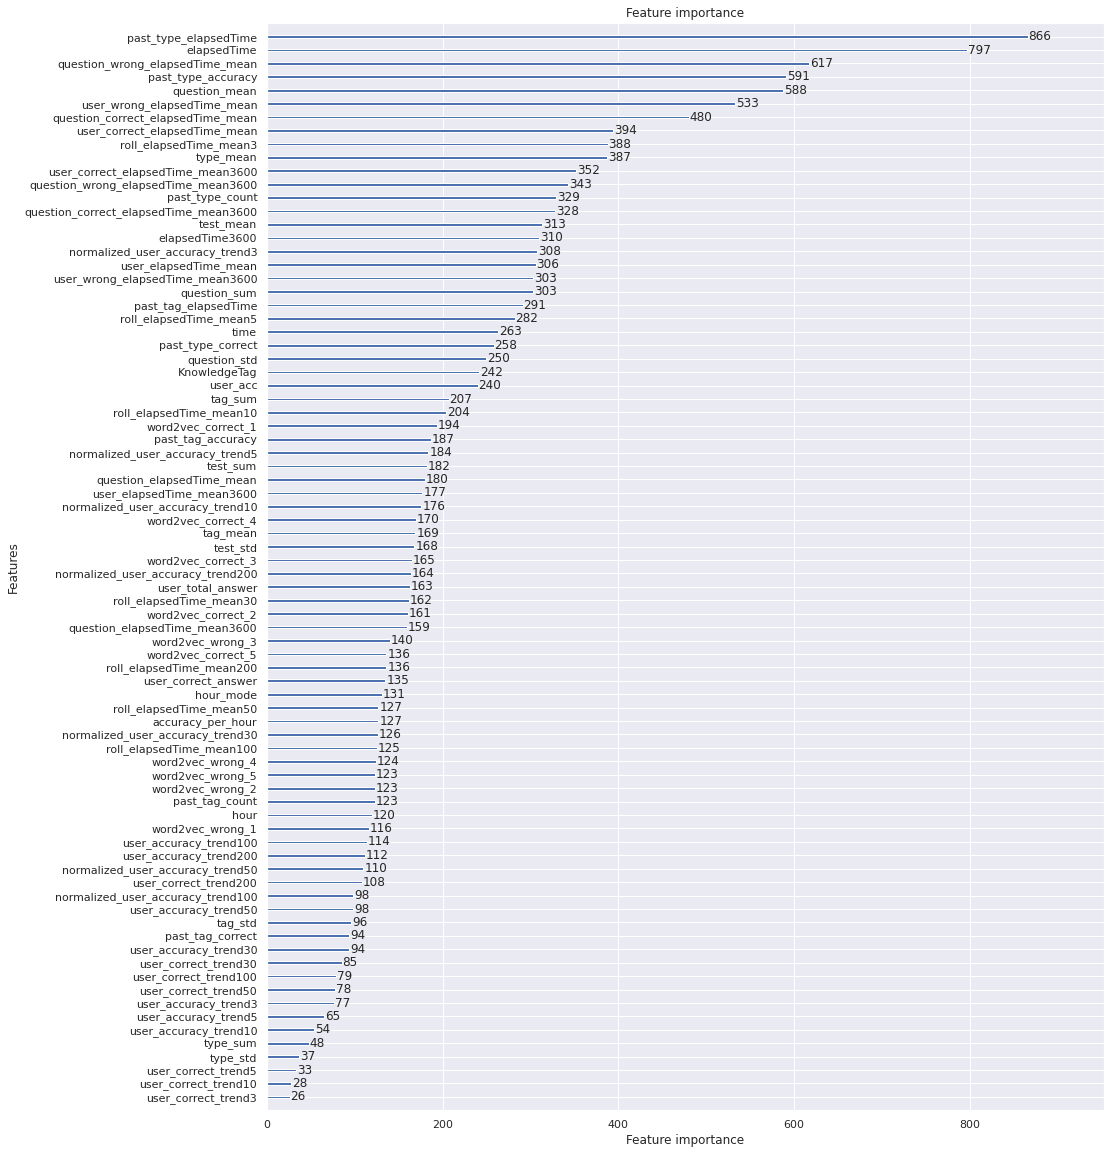

In [15]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model, figsize=(15,20))

## 5. Inference

In [16]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [17]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission3-3.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/submission3-3.csv
